In [ ]:
# Netlist Parser in Farid Problem 1.1
# The parser should not be case-sensitive, and should interpret any contiguous sequence of
# spaces or tabs as equivalent to a single space. Every line of the input file
# should describe a single circuit element, and the description of every circuit
# element should be given wholly within a single input line. The order of
# lines in the input file is immaterial and any characters following a % in
# an input line should be considered as comments and ignored. Circuit node
# names should be non-negative integers, and the node name 0 should be reserved 
# and used for the ground or reference node.

# The accepted circuit elements and their specifications are given below.
# The <value> given for a circuit parameter, like resistance or
# capacitance, should be in the standard units: Volt, Ampere, Ohm, Farad, or
# Henry, but it should not include the corresponding unit. Finally, anything
# inside brackets, such as [G2] or [<value>] is an optional field.

# • Voltage source: Only independent DC voltage sources are allowed, specified as:
# V<int> <node.+> <node.-> <value>
# • Current source: Only independent DC current sources are allowed, specified as:
# I<int> <node.+> <node.-> <value> [G2]
# • Resistor: Only linear resistors are allowed, specified as:
# R<int> <node.+> <node.-> <value> [G2]
# • Capacitor: Only linear capacitors are allowed, specified as:
# C<int> <node.+> <node.-> <value> [G2]
# • Inductor: Only linear inductors are allowed, specified as:
# L<int> <node.+> <node.-> <value>

# • Diode: The diode model, and its parameter values, will not be part of the
# input description. Instead, the model will be built into any subsequent
# simulation code that you will write and only the terminals should be
# specified here. Optionally, a scale factor can also be included so as to
# allow the specification of diodes that are larger than minimum size. The
# specification is:
# D<int> <node.+> <node.-> [<value>]
# • BJT: Similar to the diode model, only the terminals and an optional scale
# factor are given. Let QN denote an npn device and QP denote pnp; the
# specification is:
# QN<int> <node.C> <node.B> <node.E> [<value>]
# QP<int> <node.C> <node.B> <node.E> [<value>]
# where the nodes represent the collector, base, and emitter terminals,
# respectively.
# • MOSFET: Similar to the above, we give only the terminals and an
# optional scale factor, and the body terminal is to be ignored:
# MN<int> <node.D> <node.G> <node.S> [<value>]
# MP<int> <node.D> <node.G> <node.S> [<value>]
# where MN denotes an n-channel device and MP is p-channel, and the nodes
# represent the drain, gate, and source terminals, respectively.

In [2]:
filename = "netlist.sp"

with open(filename, 'r') as f:
    lines = f.readlines()

from collections import namedtuple
from collections import defaultdict

TwoTerminal = namedtuple('TwoTerminal', 'name_index, node_pos, node_neg, value, group')
ThreeTerminal = namedtuple('ThreeTerminal', 'name_index, node_D, node_G, node_S, scale')

twoTerminalTypes = ['V', 'I', 'R', 'C', 'L', 'D']
threeTerminalTypes = ['Q', 'M']
types = twoTerminalTypes + threeTerminalTypes

group2types = ['V', 'L']

elemlst = defaultdict(list)
# for type in types:
#     lst[type]

def int_with_nonegative_assert(value: float):
    assert(value.is_integer() and int(value) >= 0)
    return int(value)

for line in lines:
    line = str.upper(line)
    line = line.split('%')[0]  # neglect comments
    tokens = line.split()

    if not tokens:
        break

    type = tokens[0][0]

    if type == 'D':
        assert(len(tokens) >= 3)
    else:
        assert(len(tokens) >= 4)
    
    if type in twoTerminalTypes:
        name_index = int_with_nonegative_assert(float(tokens[0][1:]))
        node_pos = int_with_nonegative_assert(float(tokens[1]))
        node_neg = int_with_nonegative_assert(float(tokens[2]))

        value = float(tokens[3])
        assert(value >= 0)

        # Set default membership
        group = "G2" if type in group2types else "G1"

        if len(tokens) == 5:
            group = tokens[4]
            assert(group == "G2")

        elemlst[type].append(TwoTerminal(name_index, node_pos, node_neg, value, group))

    elif type in threeTerminalTypes:
        fulltype = tokens[0][0:2]

        name_index = int_with_nonegative_assert(float(tokens[0][2:]))
        node_D = int_with_nonegative_assert(float(tokens[1]))
        node_G = int_with_nonegative_assert(float(tokens[2]))
        node_S = int_with_nonegative_assert(float(tokens[3]))

        scale = 1
        if len(tokens) == 5:
            scale = float(tokens[4])
            assert(scale >= 0)

        elemlst[fulltype].append(ThreeTerminal(name_index, node_D, node_G, node_S, scale))

    else:
        raise(Exception("Unkown Type"))
    
elemlst

defaultdict(list,
            {'V': [TwoTerminal(name_index=1, node_pos=5, node_neg=0, value=2.0, group='G2'),
              TwoTerminal(name_index=2, node_pos=3, node_neg=2, value=0.2, group='G2'),
              TwoTerminal(name_index=3, node_pos=7, node_neg=6, value=2.0, group='G2')],
             'I': [TwoTerminal(name_index=1, node_pos=4, node_neg=8, value=0.001, group='G1'),
              TwoTerminal(name_index=2, node_pos=0, node_neg=6, value=0.001, group='G1')],
             'R': [TwoTerminal(name_index=1, node_pos=1, node_neg=5, value=1.5, group='G1'),
              TwoTerminal(name_index=2, node_pos=1, node_neg=2, value=1.0, group='G1'),
              TwoTerminal(name_index=3, node_pos=5, node_neg=2, value=50.0, group='G2'),
              TwoTerminal(name_index=4, node_pos=5, node_neg=6, value=0.1, group='G1'),
              TwoTerminal(name_index=5, node_pos=2, node_neg=6, value=1.5, group='G1'),
              TwoTerminal(name_index=6, node_pos=3, node_neg=4, value=0.1, group

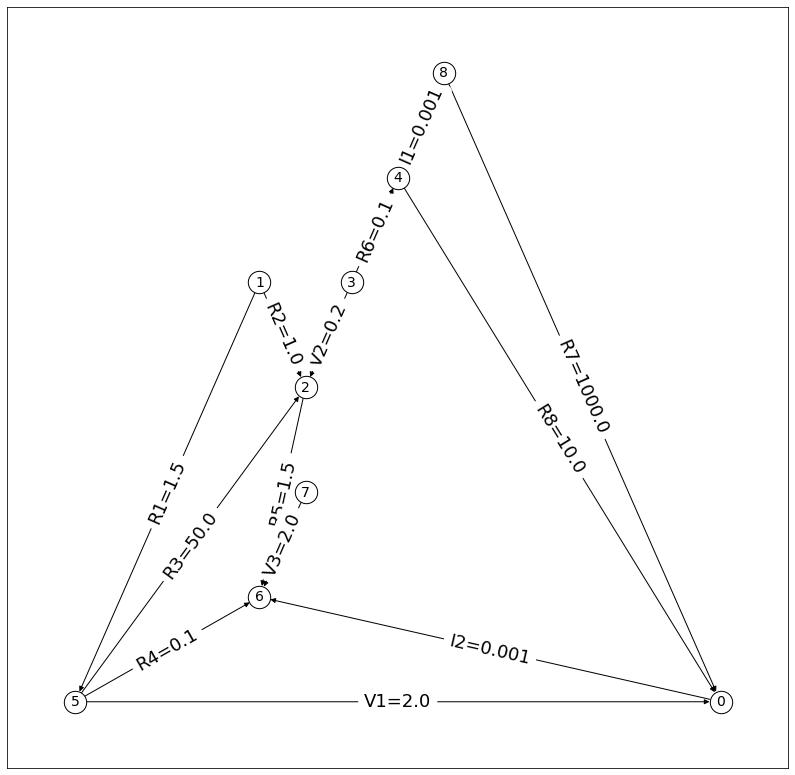

In [57]:
# Efforts to visualize the circuit
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
for type in elemlst.keys():
    if type not in twoTerminalTypes:
        continue
    for elem in elemlst[type]:
        name = type + str(elem.name_index) + "=" + str(elem.value)
        graph.add_edge(elem.node_pos, elem.node_neg, label=name)

options = {
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black",
    "font_size": 14,
}

pos = nx.planar_layout(graph)
# pos = nx.nx_pydot.pydot_layout(graph, 'dot')
labels = {x[:2]: graph.get_edge_data(*x)['label']  for x in graph.edges}

plt.figure(figsize=(14,14)) 
_ = nx.draw_networkx(graph, pos, **options)
_ = nx.draw_networkx_edge_labels(graph, pos, labels, font_size=18)


In [40]:
# MNA Element Stamping
import numpy as np
import scipy as sp

group2_count = 0
nodes = set()
for type in elemlst.keys():
    if type in twoTerminalTypes:
        for elem in elemlst[type]:
            nodes.add(elem.node_pos)
            nodes.add(elem.node_neg)
            
            if elem.group == "G2":
                group2_count += 1
    
    elif type in threeTerminalTypes:
        raise(NotImplementedError)
    
    else:
        raise("Unknown Type")
    
nodes_count = len(nodes)
matrix_size_n = matrix_size_m = group2_count + nodes_count

# Element Stamping
A = np.zeros((matrix_size_n, matrix_size_m))
rhs = np.zeros((matrix_size_n, 1))
current_index = nodes_count

for type in elemlst.keys():
    if type in twoTerminalTypes:
        if type == 'V':
            for elem in elemlst[type]:
                node_pos = elem.node_pos
                node_neg = elem.node_neg
                value = elem.value
                group = elem.group

                A[node_pos, current_index] += 1
                A[node_neg, current_index] += -1
                A[current_index, node_pos] += 1
                A[current_index, node_neg] += -1
                rhs[current_index, 0] += value

                current_index += 1
                
        if type == 'I':
            for elem in elemlst[type]:
                node_pos = elem.node_pos
                node_neg = elem.node_neg
                value = elem.value
                group = elem.group

                if group == "G1":
                    rhs[node_pos, 0] += -value
                    rhs[node_neg, 0] += value
                elif group == "G2":
                    A[node_pos, current_index] += 1
                    A[node_neg, current_index] += -1
                    A[current_index, current_index] += 1
                    rhs[current_index, 0] += value

                    current_index += 1
                else:
                    raise("Error Element Group")
                
        if type == 'R':
            for elem in elemlst[type]:
                node_pos = elem.node_pos
                node_neg = elem.node_neg
                value = elem.value
                group = elem.group
                
                if group == "G1":
                    conductance = 1 / value
                    A[node_pos, node_pos] += conductance
                    A[node_neg, node_neg] += conductance
                    A[node_pos, node_neg] += -conductance
                    A[node_neg, node_pos] += -conductance
                elif group == "G2":
                    A[node_pos, current_index] += 1
                    A[node_neg, current_index] += -1
                    A[current_index, node_pos] += 1
                    A[current_index, node_neg] += -1
                    A[current_index, current_index] += -value

                    current_index += 1
                else:
                    raise("Error Element Group")
    
    elif type in threeTerminalTypes:
        raise(NotImplementedError)
    
    else:
        raise("Unknown Type")

# Reordering
# perm = [0, 4, 8, 3, 2, 6, 5, 1, 7, 13, 12, 11, 10, 9]
# P = np.eye(14)[perm,:]
# A = P @ A @ P.transpose()
# rhs = P @ rhs

# remove ground node
A = A[1:, 1:]
rhs = rhs[1:, 0]

print(sp.sparse.coo_matrix(A), sp.sparse.coo_matrix(rhs))


  (0, 0)	1.6666666666666665
  (0, 1)	-1.0
  (0, 4)	-0.6666666666666666
  (1, 0)	-1.0
  (1, 1)	1.6666666666666665
  (1, 5)	-0.6666666666666666
  (1, 9)	-1.0
  (1, 11)	-1.0
  (2, 2)	10.0
  (2, 3)	-10.0
  (2, 9)	1.0
  (3, 2)	-10.0
  (3, 3)	10.0
  (3, 12)	1.0
  (4, 0)	-0.6666666666666666
  (4, 4)	10.666666666666666
  (4, 5)	-10.0
  (4, 8)	1.0
  (4, 11)	1.0
  (5, 1)	-0.6666666666666666
  (5, 4)	-10.0
  (5, 5)	10.666666666666666
  (5, 10)	-1.0
  (6, 10)	1.0
  (7, 7)	0.001
  (8, 4)	1.0
  (9, 1)	-1.0
  (9, 2)	1.0
  (10, 5)	-1.0
  (10, 6)	1.0
  (11, 1)	-1.0
  (11, 4)	1.0
  (11, 11)	-50.0
  (12, 3)	1.0
  (12, 12)	-10.0   (0, 3)	-0.001
  (0, 5)	0.001
  (0, 7)	0.001
  (0, 8)	2.0
  (0, 9)	0.2
  (0, 10)	2.0
